## Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import itertools
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101V2
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from keras import optimizers
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

## Preprocessing Data

In [2]:
train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_generator=train_datagen.flow_from_directory('Dataset', target_size=(128,128), color_mode='rgb', batch_size=30, shuffle='True', subset='training')
validation_generator=train_datagen.flow_from_directory('Dataset', batch_size=64, shuffle=False, target_size=(128,128), subset='validation')

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


## Create The Model

In [4]:
# Load the ResNet50V2
baseModel=ResNet101V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(128,128,3)))

# Construct the new head of the model
headModel=baseModel.output
headModel=AveragePooling2D(pool_size=(4,4))(headModel) # input layer
headModel=Flatten(name="flatten")(headModel)
headModel=Dense(64, activation="relu")(headModel) # hidden layer
headModel=Dropout(0.5)(headModel)
headModel=Dense(2, activation="softmax")(headModel) # output layer

# place the new head model on top of the base model
model=Model(inputs=baseModel.input, outputs=headModel)

# freeze the base model
for layer in baseModel.layers:
    layer.trainable=False

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 50s 0us/step


In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 32, 32,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 34, 34,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 32, 32,    │          0 │ conv2_block1_0_c

 Total params: 42,757,826 (163.11 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 42,626,560 (162.61 MB)

## Training The Model

In [6]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 and logs.get('val_accuracy') > 0.98):
            self.model.stop_training=True

stopTraining=Callback()

In [8]:
history=model.fit(train_generator, validation_data=validation_generator, epochs=15, callbacks=[stopTraining])

c:\Users\LENOVO\Desktop\Portfolio_AI\P33\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


c:\Users\LENOVO\Desktop\Portfolio_AI\P33\venv\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor']. Received: the structure of inputs=*
  warnings.warn(


90/90 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.7970 - loss: 0.7034 - val_accuracy: 0.9067 - val_loss: 0.2432
Epoch 2/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.8999 - loss: 0.2510 - val_accuracy: 0.9200 - val_loss: 0.2503
Epoch 3/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9369 - loss: 0.1854 - val_accuracy: 0.9167 - val_loss: 0.2431
Epoch 4/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9367 - loss: 0.1635 - val_accuracy: 0.9133 - val_loss: 0.2435
Epoch 5/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.9206 - loss: 0.1868 - val_accuracy: 0.9233 - val_loss: 0.2327
Epoch 6/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9487 - loss: 0.1423 - val_accuracy: 0.9033 - val_loss: 0.2174
Epoch 7/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9482 - loss: 0.1366 - val_accuracy: 0.9233 - val_loss: 0.1977
Epoch 8/15
90/90 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9508 - loss: 0.1323 - val_accuracy: 0.9200 - val_loss: 0.

## Evaluasi

In [9]:
predicts_vectors=model.predict(validation_generator, verbose=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 4s/step


In [10]:
pred=np.argmax(predicts_vectors, axis=1)

In [11]:
lb=LabelBinarizer()
lb.fit(validation_generator.labels)

y_test=lb.transform(validation_generator.labels)
y_pred=lb.transform(pred)

In [12]:
y_true=validation_generator.labels
y_pred=pred

recall=recall_score(y_true, y_pred, average='macro')
precision=precision_score(y_true, y_pred, average='macro')
f1=f1_score(y_true, y_pred, average='macro')
acc=accuracy_score(validation_generator.labels, pred)

In [13]:
print(y_true)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [14]:
print(y_pred)

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1
 1 1 1 1]


In [15]:
print('>>>> Result <<<<')
print('Accuracy: {}'.format(acc*100))
print('Recall: {}'.format(recall*100))
print('Precision: {}'.format(precision*100))
print('F1-Score: {}'.format(f1))

>>>> Result <<<<
Accuracy: 93.0
Recall: 93.0
Precision: 93.0938488263329
F1-Score: 0.9299618681282031


In [16]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       150
           1       0.91      0.95      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



In [17]:
def get_confusion_matrix(y_true, y_pred):
    n_classes=len(np.unique(y_true))
    conf=np.zeros((n_classes, n_classes))
    for actual, pred in zip(y_true, y_pred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [18]:
conf=get_confusion_matrix(y_test, y_pred)
conf

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_11748\2394499196.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  conf[int(actual)][int(pred)] += 1


array([[136,  14],
       [  7, 143]])

Text(0.5, 23.52222222222222, 'Predicted Label')

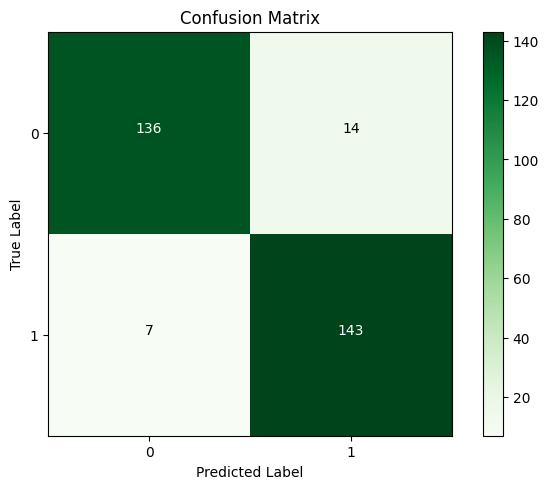

In [19]:
classes=[0, 1]

# Plot Confusion Matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks=np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt='d'
thresh=conf.max()/2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')